# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 8</span>


During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on two variational parameters, $\sigma$, which is the width of the two Gaussians under square root, and $\mu$, which represents the distance from the origin of their average values.

### Exercise 8.1

Write a C++ Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample a trial wave function $|\Psi_T(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. Using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity.

The expectation value of the Hamiltonian is determined by computing the integral as we did back in Lecture 2. The normalised wavefunction represents the probability density for the particle to be found exactly in $x$, so we can use this property to estimate the integral: by sampling this wavefunction with the Metropolis algorithm, tracking the possible movements of the particle in the potential, we can estimate the integral as the average of the term 
$$ \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$$
using as wavefunction the hypotetical sum of two gaussians. It can be noticed that the exact normalisation of the wavefunction is irrelevant: the acceptance probability for the Metropolis algorithm is the ratio between the previous and current probability density, which have the same normalisation and therefore simplifies.

The code to implement this is a variation of what already written for the sampling of the wavefunction of the hydrogen atom, simply modyfing the probability density the walk needs to be fed to accept or not the move.

### Exercise 08.2

Use your Variational Monte Carlo code to find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$:

$$
\langle {\hat H} \rangle_T = \frac{\langle \Psi_T^{\sigma,\mu}| {\hat H} | \Psi_T^{\sigma,\mu} \rangle}
{\langle \Psi_T^{\sigma,\mu} | \Psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

- As usual, <span style="color:red">show a picture of the estimation of $\langle {\hat H} \rangle_T$ </span> and its statistical uncertainty as a function of the number of blocks/MC steps for the set of parameters which minimize $\langle {\hat H} \rangle_T$
- <span style="color:red">show also a picture **of the sampled** $|\Psi_T(x)|^2$</span> by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below).

The wavefunction used in the evolution is just an Ansatz of how we expect the eigenfunction of the hamiltonian. Since it is only an approximation, the average energy does not represent exactly the ground state level. However, it is possible to get as close as possible by determining the optimal parameters for the wavefunction to approximate as best as possible the ground state eigenfunction.

To do this, I simply run the code varying the parameters $\mu$ and $\sigma$ one at the time, in order to determine the tuple which corresponds to the lower bound for the integral.

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy import optimize

In [3]:
# Solution of ground state eigenfunction
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

def expWF(x, mu, sigma):
    return (np.exp(-(mu-x)**2 / sigma) + np.exp(-(mu + x)**2 /sigma))

def exp_fit (x, m, s, N):
    return N*(np.exp(-(x-m)**2/(2*s*s)) + np.exp(-(x+m)**2/(2*s*s)))

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)
# Theoretical curve: take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

In [4]:
data = np.loadtxt("data_8_1/min_energy_search.txt", unpack = 'true')

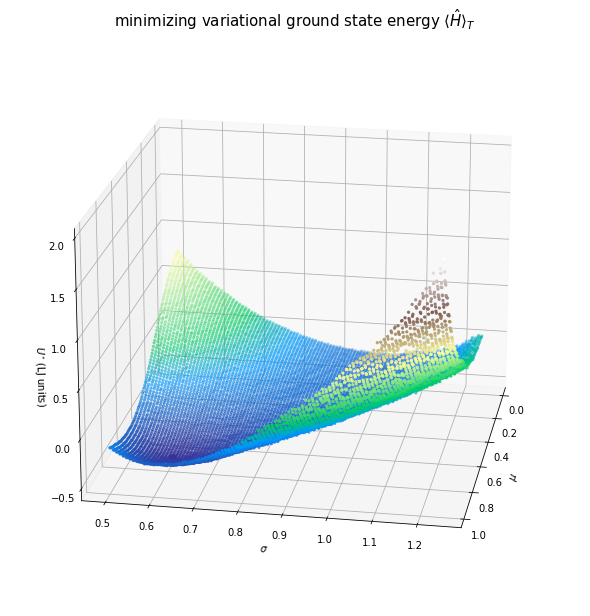

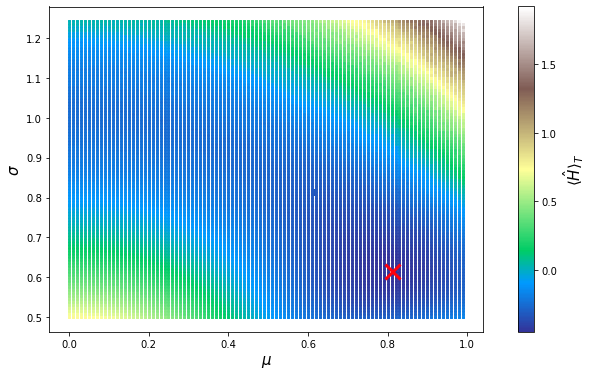

Minimum values are:
	E_min = -0.448876
	mu = 0.81
	sigma = 0.616


In [9]:
fig = plt.figure(figsize=[8,8])
ax = Axes3D(fig)

ax.scatter(*data,c=data[2], marker='.', cmap = "terrain")
ax.set_title(r"minimizing variational ground state energy $\langle {\hat H} \rangle_T$", size=15)


ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('$U^{\star}$ (LJ units)' )

ax.view_init(20, 10)

# find minimum energy
E_min = np.min(data[2])
min_index = np.argmin(data[2])
mu_min = data[0][min_index]
sigma_min = data[1][min_index]

# plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(212)
pc = ax.scatter( data[0], data[1],  c=data[2], marker="s", s=4, cmap="terrain")
ax.plot( mu_min, sigma_min,  marker="x", color="xkcd:bright red", markersize=15, markeredgewidth=3)
cb = fig.colorbar(pc)
cb.set_label(label=r"$\langle {\hat H} \rangle_T$", size=15)

ax.set_xlabel(r"$\mu$", size=15)
ax.set_ylabel(r"$\sigma$", size=15)
ax.set_aspect("equal")

plt.tight_layout()
plt.show()

# print minimum values
print("Minimum values are:\n\t" + "E_min = " + str(E_min) + "\n\tmu = " + str(mu_min) + "\n\tsigma = " + str(sigma_min))

plt.show()

The optimal parameters were found by taking a grid of 100 possible values of $\mu \in [0,1]$ and $\sigma \in [0.5,1,25]$, searching for the global minimum average energy. After finding a first minimum, a second series of runs was made, varying $\mu \in [0.6155,6165]$ and $\sigma \in [0.809,0.819]$; a slight improvement was made reguarding the optimal $\sigma$, with very little difference with the previous estimate of the ground state energy. 
You may notice that there are some denser areas in the rest of the graphs: these correspond to previous attempts to find a global minimum around the best current estimate, in which, however, the domain insterted had received the wrong parameters…

As we can see from the first 3D graph, the parameters form a sort of a diagonal valley: as $\sigma$ increases, to minimise the energy $\mu$ has to increase and vice versa. We can see that the global minimum is quite close to the edge of the dominion: at first one might attempt to probe outside these first boundaries. However we notice how the borders tend to rise as we move further away from this low point, so we do not expect to find a better solution for other parameters. 

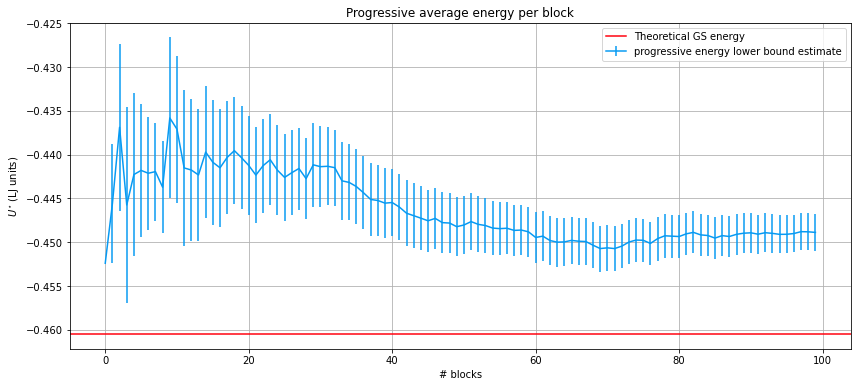

In [26]:
fig = plt.figure(figsize=[14,6])
H, H_err = np.loadtxt("data_8_1/energy_avg.txt", unpack = True)
x__ = np.arange(len(H))
plt.errorbar(x__, H, yerr=H_err, label = 'progressive energy lower bound estimate', c='xkcd:azure')
plt.axhline(y=E[0], label = 'Theoretical GS energy', c='xkcd:bright red')
plt.xlabel('# blocks')
plt.ylabel('$U^{\star}$ (LJ units)' )
plt.title('Progressive average energy per block')
plt.legend()
plt.grid(True)
plt.show()

The final average energy is still greater than the expected ground state energy value: it results slightly compatible considering a $3\sigma$ confidence interval. This does not actually surprise us: the current estimate represents the lower bound accessible with the Ansatz made on the wavefunction shape. We could try to improve the precision of the sampling or of the optimal parameters, but for most of the practical interests this result is more than sufficient: what matters is finding a simple, analytical expression for the wavefunction to approximate the ground state without resorting to differential methods.

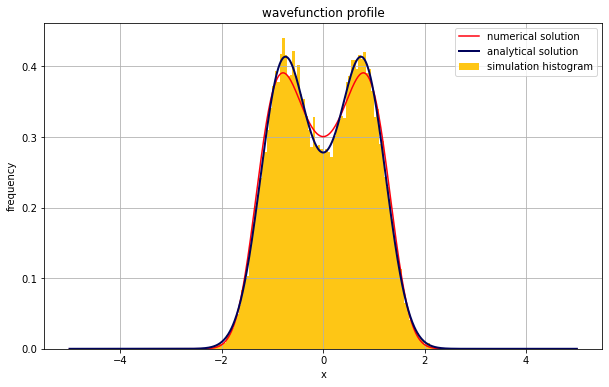

0.8112999152295202 0.6202529071614833


In [27]:
fig = plt.figure(figsize=[10,6])
x = np.linspace(-a/2, a/2, N)
plt.plot(x,(psi[0])**2, label = 'numerical solution', c= 'xkcd:bright red')

popt, popc = optimize.curve_fit(exp_fit, x, psi[0])
m_ = popt[0]
s_ = popt[1]
N_ = popt[2]
wf = N_*(np.exp(-(x-m_)**2/(2*s_*s_)) + np.exp(-(x+m_)**2/(2*s_*s_)))
plt.plot(x,wf**2, label = 'analytical solution', c= 'xkcd:dark blue', linewidth=2)

x_ = np.loadtxt("data_8_1/wavefunction.txt")
plt.hist(x_, bins=100, density= True, color='xkcd:golden yellow', label='simulation histogram')
plt.xlabel('x')
plt.ylabel('frequency')
plt.title('wavefunction profile')
plt.legend()
plt.grid(True)
plt.show()

print (m_, s_)

The histogram represents the (normalised) frequency with which each point was visited during the sampling, effectively showing the wavefunction profile. The double-exponential analytical solution presents a good correspondence with the numerical solution, both as a fit and as the histogram -which, as we can notice, correctly fills the analytical solution, sign of a correct sampling by the programme. The fit parameter $\mu ^{\star}$ and $\sigma^{\star}$ are very close to the ones the previous simulations were able to identify as optimal.

### Exercise 8.3

Use the PIMC/PIGS code we have provided to study the same 1D quantum system. Use the PIGS algorithm ($T=0$) to project
- a constant trial wave function, $\Psi_T(x)=1$
- using $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$ with the variational parameters you have optimized.

The main difficulty when considering quantum particles is that variables not always commute, introducing non-trivial constraints in the computation. In particular, when considering the canonical density matrix of a single particle

$$ \hat{\rho} = \dfrac{e^{-\beta \hat{H}}}{Tr [e^{-\beta \hat{H}}]}$$

the kinetic and potential term that make up the hamiltonian do not commute. The computation of the matrix element $\hat{\rho}(r,r') = \langle r | e^{-\beta \hat{H}} | r' \rangle$ cannot be separated in the two terms, one of which depends solely on momentum and the other on position. We can separate the kinetic and potential term using the Baker-Campbell-Hausdorff formula $e^{\hat{A}\hat{B}} = e^{\hat{A}}e^\hat{B}e^{-\frac{1}{2} [\hat{A},\hat{B}]}$, but the additional commutation term needs to be considered.

We can actually ignore the commutation term by using the Trotter decomposition of the exponential term for large $M$:
$$ e^{-\beta \hat{H}} = \left( e^{-\frac{\beta \hat{H}}{M}} \right) ^M 
    = \lim_{M\to \infty} \left( e^{-\frac{\beta \hat{T}}{M}} e^{-\frac{\beta \hat{V}}{M}} \right) $$
as the commutator term scales as $M^{-2}$, thus negligible compared to the others.

The idea behind the path integral method of computation is to introduce a series of $M$ intermediate points between the two extremes so that the density matrix element can be reduced to the product of $M$ different, equivalent terms:
$$ \hat{\rho}(r,r,\beta) = \int dr_2 \dots \int dr_M \langle r | e^{-\frac{\beta \hat{H}}{M}} |r_2 \rangle \dots \langle r_M | e^{-\frac{\beta \hat{H}}{M}} |r \rangle $$

The potential term can be spilt in two and determined in the two intermediate positions, while the kinetic term can be read as a Boltzmann weight of an harmonic interacton between the points $r_i$ and $r_{i+1}$.  
$$ \langle r_i | e^{-\frac{\beta \hat{H}}{M}} |r_{i+1} \rangle \approx 
\langle r_i | e^{-\frac{\beta}{M}\frac{\hat{V}}{2}} e^{-\frac{\beta \hat{T}}{M}}  e^{-\frac{\beta \hat{T}}{M}}  e^{-\frac{\beta}{M}\frac{\hat{V}}{2}} |r_{i+1} \rangle = 
e^{-\frac{\beta}{M}\frac{V(r_i)}{2}} \dfrac{e^{-|r_i - r_{i+1}|^2 \frac{M}{4\lambda \beta}}}{(4\pi\lambda \beta/M)^{3/2} } e^{-\frac{\beta}{M}\frac{V(r_{i+1})}{2}} $$

This is known as the "primitive" approximation of the matrix element: a set of $N$ interacting quantum particles is isomorph to a set of $N$ interacting classical ring polymers of $M$ elements, bound with elastic forces. 
The code therefore iterprets the single quantum particle as a single polymer of 300 identical particles, which represent the intermediate steps in the path integral.

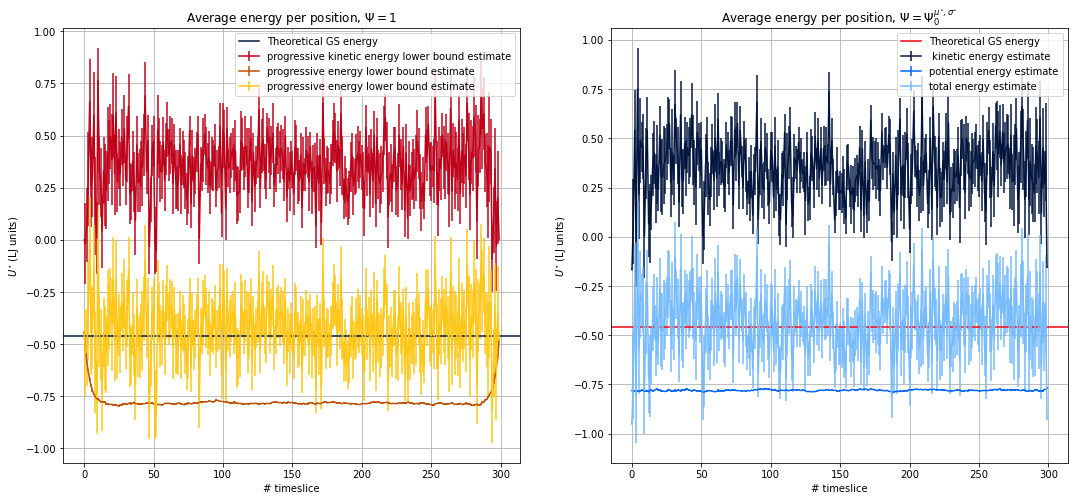

In [28]:
fig,ax = plt.subplots(1,2, figsize=[18,8])
#uniform probabilty energy estimate
bl_no,k_uni, k_err_uni = np.loadtxt("QMC_1D_data/kinetic_uni0.000000.txt", unpack = True)
bl_no,V_uni, V_err_uni = np.loadtxt("QMC_1D_data/potential_uni0.000000.txt", unpack = True)
H_uni = k_uni + V_uni
H_uni_err = k_err_uni+V_err_uni
x__ = np.arange(len(H_uni))
ax[0].errorbar(bl_no, k_uni, yerr=k_err_uni, label = 'progressive kinetic energy lower bound estimate',c='xkcd:scarlet' )
ax[0].errorbar(bl_no, V_uni, yerr=V_err_uni, label = 'progressive energy lower bound estimate',c= 'xkcd:burnt orange')
ax[0].errorbar(bl_no, H_uni, yerr=H_uni_err, label = 'progressive energy lower bound estimate', c='xkcd:golden yellow')
ax[0].axhline(y=E[0], label = 'Theoretical GS energy', c='xkcd:navy')

ax[0].set_xlabel('# timeslice')
ax[0].set_ylabel('$U^{\star}$ (LJ units)' )
ax[0].set_title('Average energy per position, $\Psi = 1$')
ax[0].legend()
ax[0].grid(True)

# optimal wavefunction 
bl_no,k_uni, k_err_uni = np.loadtxt("QMC_1D_data/kinetic_opt0.000000.txt", unpack = True)
bl_no,V_uni, V_err_uni = np.loadtxt("QMC_1D_data/potential_opt0.000000.txt", unpack = True)
H_uni = k_uni + V_uni
H_uni_err = k_err_uni+V_err_uni
x__ = np.arange(len(H_uni))
ax[1].errorbar(bl_no, k_uni, yerr=k_err_uni, label = ' kinetic energy estimate', c='xkcd:navy' )
ax[1].errorbar(bl_no, V_uni, yerr=V_err_uni, label = 'potential energy estimate', c='xkcd:bright blue')
ax[1].errorbar(bl_no, H_uni, yerr=H_uni_err, label = 'total energy estimate', c= 'xkcd:sky blue' )
ax[1].axhline(y=E[0], label = 'Theoretical GS energy', c='xkcd:bright red')

ax[1].set_xlabel('# timeslice')
ax[1].set_ylabel('$U^{\star}$ (LJ units)' )
ax[1].set_title('Average energy per position, $\Psi = \Psi^{\mu^{\star}, \sigma^{\star}}_0$')
ax[1].legend()
ax[1].grid(True)

plt.show()

These first results present the average ground dtate energy estimated at $T=0$. In the immaginary time evolution, the time variable is changed in order to reduce the unitary evolution to a decreasing exponential: $t = -i \tau \to i t\hat{H} = -\tau \hat{H}$. Given a generic mixed state, after a long evolution the only relevant term is the ground state, as all the others with higher temperature have all been damped by the exponential:

$$|\psi(\tau)\rangle = e^{-\tau \hat{H}}\sum_n c_n |\psi_n\rangle = \sum_n e^{-\tau E_n} c_n |\psi_n\rangle \approx _{\tau \gg 1} c_o |\psi_0\rangle$$

This way we are sure that, given any random polymer, after a long enough Monte Carlo evolution the energy of the polymer will correspond exaclty to the ground state energy. We compare the results using as probability for the Metropolis acceptance first a uniform probability and afterwards the optimal wavefunction we found previously.

We see how the kinetic energy has high fluctuations in both cases, since it is computed as the harmonic potential between two consecutive positions, which strongly depend on the particular configuration sampled. The main difference can be seen with the potential energy: the uniform wavefunction presents much larger border effects, due to the fact that the extremes of the path integral are fixed. Nevertheless, the two results are compatible one another: the resulting avrage of the hamiltonian is centred around the expected value, with very large fluctuations due to the kinetic term.

We can notice however how these numerical methods to approximate the quantum particle to a classical polymer are valid only after a long enough evolution, for $\tau \gg 1$. By changing the value of the immaginary time propagation, we compare the effect on the potential energy estimate (we do not consider the effects on the kinetic term):

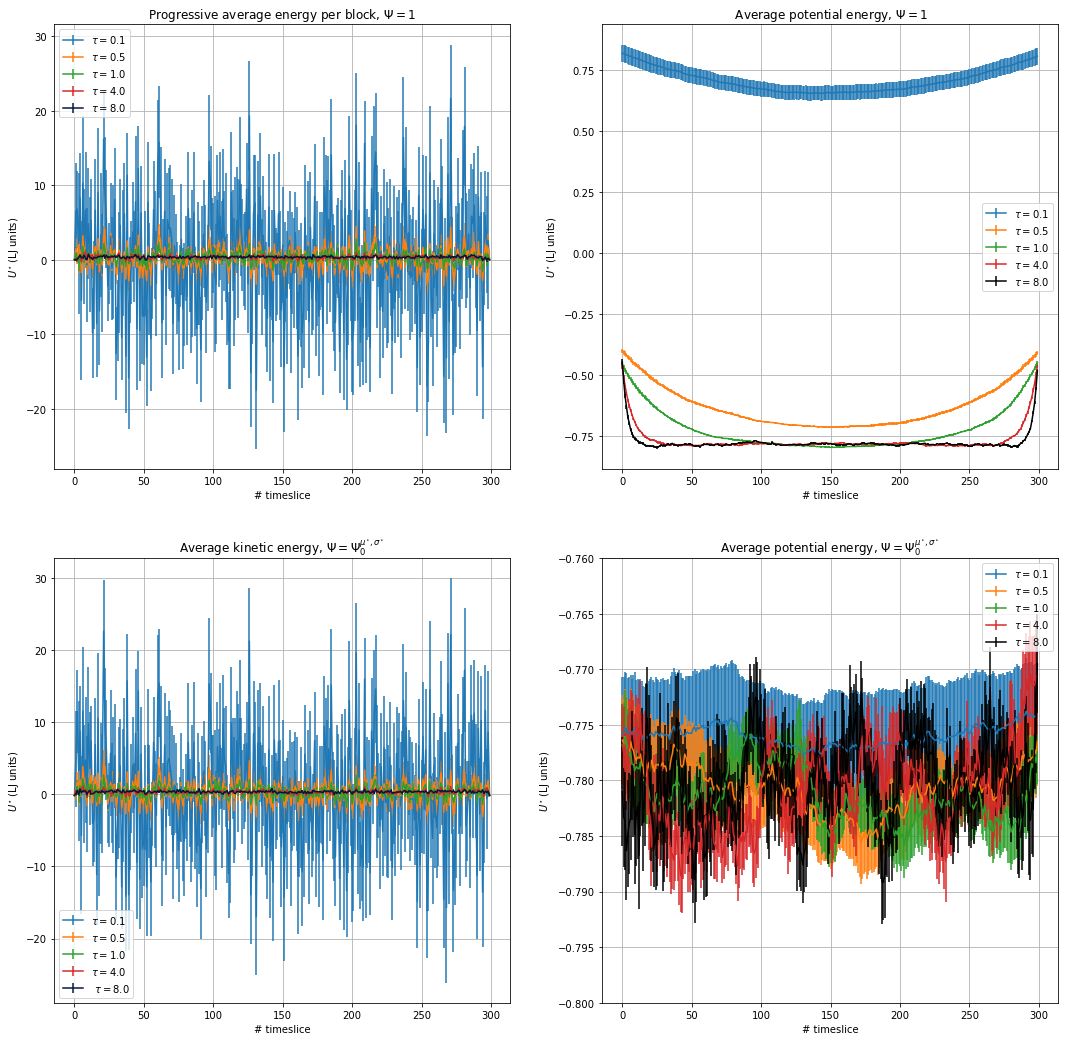

In [16]:
fig,ax = plt.subplots(2,2, figsize=[18,18])
im_t = [0.1,0.5,1.0,4.0]

#uniform probabilty kinetic energy 
for i in im_t:
    bl_no, V_uni, V_err_uni = np.loadtxt("QMC_1D_data/kinetic_uni_"+str(i)+".txt", unpack = True)
    ax[0][0].errorbar(bl_no, V_uni, yerr=V_err_uni, label = '$\\tau = $' +str(i))
bl_no,k_uni, k_err_uni = np.loadtxt("QMC_1D_data/kinetic_uni0.000000.txt", unpack = True)
ax[0][0].errorbar(bl_no, k_uni, yerr=k_err_uni, label = '$\\tau = 8.0$', c='xkcd:navy')

ax[0][0].set_xlabel('# timeslice')
ax[0][0].set_ylabel('$U^{\star}$ (LJ units)' )
ax[0][0].set_title('Progressive average energy per block, $\Psi = 1$')
ax[0][0].legend()
ax[0][0].grid(True)

# uniform potential
for i in im_t:
    bl_no,V_uni, V_err_uni = np.loadtxt("QMC_1D_data/potential_uni_"+str(i)+".txt", unpack = True)
    ax[0][1].errorbar(bl_no, V_uni, yerr=V_err_uni, label = '$\\tau = $' +str(i))
bl_no,V_uni, V_err_uni = np.loadtxt("QMC_1D_data/potential_uni0.000000.txt", unpack = True)
ax[0][1].errorbar(bl_no, V_uni, yerr=V_err_uni, label = '$\\tau = 8.0$',c= 'xkcd:black')

ax[0][1].set_xlabel('# timeslice')
ax[0][1].set_ylabel('$U^{\star}$ (LJ units)' )
ax[0][1].set_title(' Average potential energy, $\Psi = 1$')
ax[0][1].legend()
ax[0][1].grid(True)

# optimal wavefunction kinetic energy
for i in im_t:
    bl_no, V_uni, V_err_uni = np.loadtxt("QMC_1D_data/kinetic_opt_"+str(i)+".txt", unpack = True)
    ax[1][0].errorbar(bl_no, V_uni, yerr=V_err_uni, label = '$\\tau = $' +str(i))

bl_no,k_uni, k_err_uni = np.loadtxt("QMC_1D_data/kinetic_opt0.000000.txt", unpack = True)
ax[1][0].errorbar(bl_no, k_uni, yerr=k_err_uni, label = ' $\\tau = 8.0$', c='xkcd:navy' )
ax[1][0].set_xlabel('# timeslice')
ax[1][0].set_ylabel('$U^{\star}$ (LJ units)' )
ax[1][0].set_title('Average kinetic energy, $\Psi = \Psi^{\mu^{\star}, \sigma^{\star}}_0$')
ax[1][0].legend()
ax[1][0].grid(True)

# optimal wavefunction potential energy
for i in im_t:
    bl_no,V_uni, V_err_uni = np.loadtxt("QMC_1D_data/potential_opt_"+str(i)+".txt", unpack = True)
    ax[1][1].errorbar(bl_no, V_uni, yerr=V_err_uni, label = '$\\tau = $' +str(i))
bl_no,V_uni, V_err_uni = np.loadtxt("QMC_1D_data/potential_opt0.000000.txt", unpack = True)
ax[1][1].errorbar(bl_no, V_uni, yerr=V_err_uni, label = '$\\tau = 8.0$', c='xkcd:black')
ax[1][1].set_xlabel('# timeslice')
ax[1][1].set_ylabel('$U^{\star}$ (LJ units)' )
ax[1][1].set_title('Average potential energy, $\Psi = \Psi^{\mu^{\star}, \sigma^{\star}}_0$')
ax[1][1].legend()
ax[1][1].set_ylim([-0.8,-0.76])
ax[1][1].grid(True)

plt.show()

We can clearly see that the immaginary time interval  has a great impact on the simulation. The kinetic term gains much larger fluctuations as $\tau \to 0$, in a way which is indipendent on the wavefunction used to sample. Reguarding the potential energy, we can see that the border contraints are much more evident, to the point in which it is not even comparable with the best numerical approximation. On the other hand, for the optimal wavefunction, the mess we see in the graph is actually good news: it means that all estimates overlap quite well over one another! As $\tau$ decreases the uncertainty increases, but it remains compatible with the other estimates.

The difference of sampling probability density is thus evident not in the ideal case of $\tau \gg 1$, where we have seen the two distribution yield almost identical results, but as we try to shorten the evolution times. A better approximation of the actual ground state eigenstate allows to decrease almost hundredfold the interval length: this is great news for simulations which need to sample the evolution of the system in very small intervals.

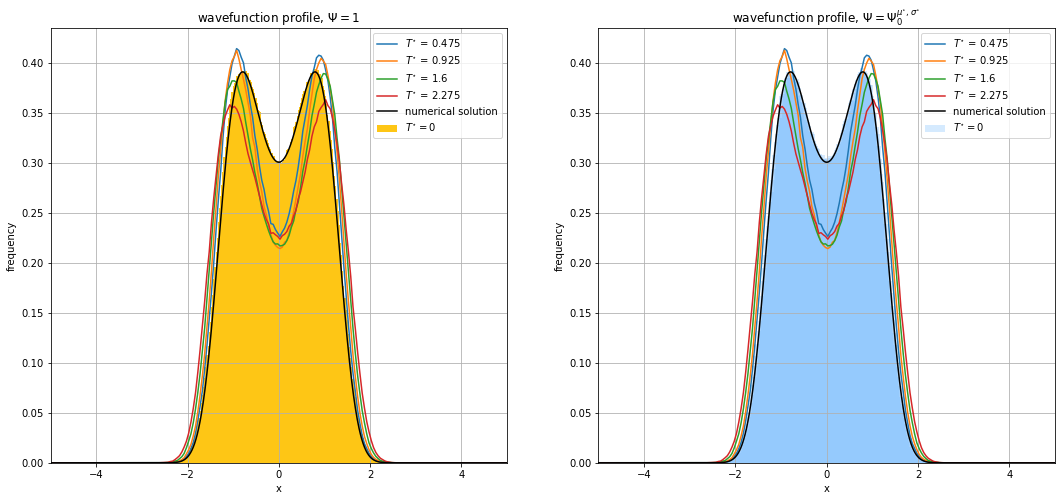

In [30]:
fig,ax = plt.subplots(1,2, figsize=[18,8])

ran = [1,3,6,9]
#uniform wave function
for i in ran:
    temp = 0.25 + 2.25*i/10 
    x_,wf,err = np.loadtxt("QMC_1D_data/probability_uni"+str(temp)+".txt", unpack =True)
    ax[0].plot(x_, wf, label='$T^{\star}$ = '+str(temp))
x_,wf,err = np.loadtxt("QMC_1D_data/probability_uni0.000000.txt", unpack =True)
ax[0].bar(x_, wf, width=0.1, color='xkcd:golden yellow', label='$T^{\star}=0$')
ax[0].plot(x,(psi[0])**2, label = 'numerical solution', c= 'xkcd:black')
ax[0].set_xlabel('x')
ax[0].set_xlim([-5,5])
ax[0].set_ylabel('frequency')
ax[0].set_title('wavefunction profile, $\Psi = 1$')
ax[0].legend()
ax[0].grid(True)

#uniform wave function
for i in ran:
    temp = 0.25 + 2.25*i/10 
    x_,wf,err = np.loadtxt("QMC_1D_data/probability_opt"+str(temp)+".txt", unpack =True)
    ax[1].plot(x_, wf, label='$T^{\star}$ = '+str(temp))
x_,wf,err = np.loadtxt("QMC_1D_data/probability_opt0.000000.txt", unpack =True)
ax[1].bar(x_, wf, width=0.1, color='xkcd:sky blue', label='$T^{\star}=0$', alpha = 0.3)
ax[1].plot(x,(psi[0])**2, label = 'numerical solution', c= 'xkcd:black')
ax[1].set_xlabel('x')
ax[1].set_xlim([-5,5])
ax[1].set_ylabel('frequency')
ax[1].set_title('wavefunction profile, $\Psi = \Psi^{\mu^{\star}, \sigma^{\star}}_0$')
ax[1].legend()
ax[1].grid(True)

plt.show()

By comparing the wavefunction profiles at different temperatures we clearly see how it progressively furthers from the theoretical wavefunction. While at $T^{\star}=0$ the fit is nearly optimal, the two peaks get lower and with a greater distance between them. At null temperature the ground state eigenstate is the only component of the wave function, whereas at higher temperatures also other terms are present, distorting the wavefunction from the ideal shape.

### Supplementary material

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.

Ground state energy:  -0.46046587969271535
1st excited state energy:  0.0974247133176107
2nd excited state energy:  1.9717331343930204


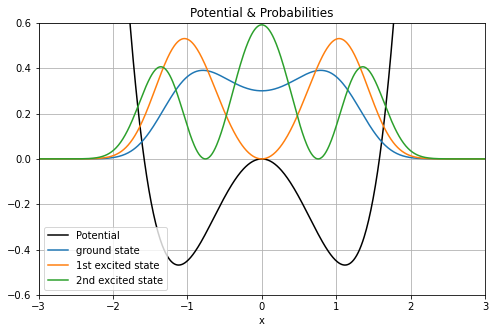

In [8]:
print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2, label = 'ground state')
plt.plot(x,(psi[1])**2, label = '1st excited state')
plt.plot(x,(psi[2])**2, label = '2nd excited state')
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.legend()
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.show()

In [9]:
def exp_fit (x, m, s, N):
    return N*(np.exp(-(x-m)**2/(2*s*s)) + np.exp(-(x+m)**2/(2*s*s)))

popt, popc = optimize.curve_fit(exp_fit, x, psi[0])
m_ = popt[0]
s_ = popt[1]
N_ = popt[2]
print (popt)

[0.81129992 0.62025291 0.62023546]
